In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from vgg_models.vgg import vgg13_bn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Load the CIFAR-10 test dataset -------------

normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616))

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)


# ------------- Load the pretrained model ------------
model = vgg13_bn(pretrained=True)
model = model.to(device)
model.eval()

/Users/charleslego/opt/anaconda3/envs/DL_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Files already downloaded and verified


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [3]:
idx = 1
x = test_dataset[idx][0] # label: Ship (8)
x = transforms.ToTensor()(x)
label = test_dataset[idx][1]



In [6]:
labels = ['Airplane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

eps_pga = 2/255   # Perturbation size
eps_sign = eps_pga

# Create a copy of the image, but with gradient activated
x_with_grad = x.clone().detach().requires_grad_(True)
# Calculate logits
logits_sign = model(normalize(x_with_grad).unsqueeze(0))
# Calculate the loss
loss_sign = F.cross_entropy(logits_sign, torch.tensor(label).unsqueeze(0))
# Calculate the loss w.r.t to the input
loss_sign.backward()
# Create adversarial perturbation 'in one step' with sign of the gradient
r_sign = eps_pga * torch.sign(x_with_grad.grad.data)
# Create the adversarial example
x_adv_sign = x + r_sign

# Normalize the adversarial image
x_adv_sign_norm = normalize(x_adv_sign)
# Calculate the adversarial logits
logits_adv_sign = model(x_adv_sign_norm.unsqueeze(0))
# Get the 'hard' prediction for the adversarial example
pred_adv_sign = torch.argmax(logits_adv_sign)

print('The image is a', labels[pred_adv_sign])

tensor([[[-0.0078,  0.0078, -0.0078,  ...,  0.0078,  0.0078,  0.0078],
         [ 0.0078, -0.0078, -0.0078,  ...,  0.0078, -0.0078,  0.0078],
         [-0.0078,  0.0078, -0.0078,  ..., -0.0078,  0.0078, -0.0078],
         ...,
         [-0.0078,  0.0078, -0.0078,  ..., -0.0078,  0.0078,  0.0078],
         [ 0.0078,  0.0078, -0.0078,  ..., -0.0078, -0.0078,  0.0078],
         [ 0.0078,  0.0078, -0.0078,  ...,  0.0078,  0.0078,  0.0078]],

        [[-0.0078,  0.0078,  0.0078,  ...,  0.0078,  0.0078,  0.0078],
         [ 0.0078, -0.0078,  0.0078,  ...,  0.0078, -0.0078,  0.0078],
         [-0.0078,  0.0078,  0.0078,  ..., -0.0078, -0.0078, -0.0078],
         ...,
         [-0.0078,  0.0078,  0.0078,  ..., -0.0078, -0.0078, -0.0078],
         [-0.0078,  0.0078,  0.0078,  ..., -0.0078, -0.0078,  0.0078],
         [-0.0078,  0.0078, -0.0078,  ...,  0.0078,  0.0078, -0.0078]],

        [[-0.0078, -0.0078,  0.0078,  ...,  0.0078,  0.0078,  0.0078],
         [ 0.0078, -0.0078,  0.0078,  ...,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


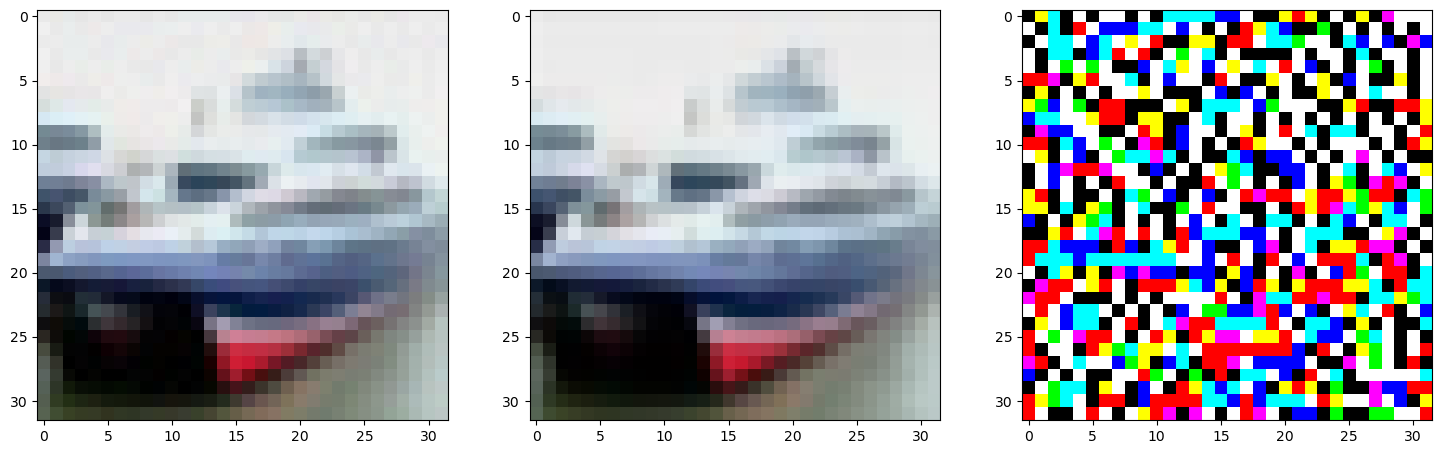

In [42]:
def clamp_to_img(x):
  return torch.clamp(x, min=0., max=1.)

plt.rcParams['figure.figsize'] = [18, 18]
fig, axs = plt.subplots(1, 3)
# Plot the adversarial example
axs[0].imshow(clamp_to_img(x_adv_sign).reshape(3,32,32).detach().numpy().transpose(1,2,0))
# Plot the original example
axs[1].imshow(clamp_to_img(x).reshape(3,32,32).numpy().transpose(1,2,0))
# Plot the scaled version of the perturbation
axs[2].imshow(r_sign.reshape(3,32,32).detach().numpy().transpose(1,2,0)/eps_sign)

In [44]:
output = r_sign.detach()

output_filename = f'adversarial_example_index_{idx}.pt'
torch.save(output, output_filename)